In [1]:
import numpy as np
import pandas as pd

from utils import KNNImageImputer, MeanImageImputer
from utils import Missingness
from utils import get_device
from utils import get_raw_data
from utils import plot_dec_performance
from utils import run_dec_pipeline

In [2]:
missingness = Missingness()
knn_imputer = KNNImageImputer(k=5)
mean_imputer = MeanImageImputer()

device = get_device()

missingness_percentages = np.arange(0, 100, 2.5)

# Loading data

In [3]:
tensor_x, labels, indices = get_raw_data('mnist', device=device)

# KNN Imputation

In [4]:
ari_scores_knn = []
nmi_scores_knn = []

In [5]:
for mcar_percent in missingness_percentages:
    missing_rate_float = mcar_percent / 100.0

    ari, nmi = run_dec_pipeline(
        X_clean=tensor_x,
        y_true=labels,
        data_indices=indices,
        missingness=missingness,
        corruption_type='mcar',
        missing_rate=missing_rate_float,
        imputer=knn_imputer,
        device=device,
        ae_epochs=30,
        dec_epochs=70
    )

    ari_scores_knn.append(ari)
    nmi_scores_knn.append(nmi)

	No corruption applied
	Running imputation: KNNImageImputer
	- Training Autoencoder
Epoch 5/30: average loss = 0.0179
Epoch 10/30: average loss = 0.0131
Epoch 15/30: average loss = 0.0114
Epoch 20/30: average loss = 0.0105
Epoch 25/30: average loss = 0.0099
Epoch 30/30: average loss = 0.0095
	- Training DEC
Epoch 10/70: average loss = 0.1622
Epoch 20/70: average loss = 0.1256
Epoch 30/70: average loss = 0.1049
Epoch 40/70: average loss = 0.0912
Epoch 50/70: average loss = 0.0811
Epoch 60/70: average loss = 0.0733
Epoch 70/70: average loss = 0.0671
	Evaluation
Result: ARI=0.7658 | NMI=0.8214
	Corrupting data (mcar | 0.03)
	Running imputation: KNNImageImputer
	- Training Autoencoder
Epoch 5/30: average loss = 0.0181
Epoch 10/30: average loss = 0.0132
Epoch 15/30: average loss = 0.0115
Epoch 20/30: average loss = 0.0106
Epoch 25/30: average loss = 0.0100
Epoch 30/30: average loss = 0.0095
	- Training DEC
Epoch 10/70: average loss = 0.1619
Epoch 20/70: average loss = 0.1246
Epoch 30/70: av

In [6]:
results_df = pd.DataFrame({
    'Missingness': missingness_percentages,
    'ARI': ari_scores_knn,
    'NMI': nmi_scores_knn
})

print(results_df)

    Missingness       ARI       NMI
0           0.0  0.765788  0.821367
1           2.5  0.761547  0.815006
2           5.0  0.770054  0.820541
3           7.5  0.765105  0.827514
4          10.0  0.729295  0.804688
5          12.5  0.762865  0.816184
6          15.0  0.737827  0.791886
7          17.5  0.756309  0.814932
8          20.0  0.762870  0.823622
9          22.5  0.725013  0.789575
10         25.0  0.743643  0.803755
11         27.5  0.768582  0.828975
12         30.0  0.688177  0.758746
13         32.5  0.708349  0.779129
14         35.0  0.713459  0.785668
15         37.5  0.762574  0.800119
16         40.0  0.721806  0.787454
17         42.5  0.732433  0.784199
18         45.0  0.741949  0.792501
19         47.5  0.727293  0.776114
20         50.0  0.728464  0.777929
21         52.5  0.716258  0.766561
22         55.0  0.679010  0.760336
23         57.5  0.719405  0.766815
24         60.0  0.604481  0.692137
25         62.5  0.684763  0.734038
26         65.0  0.667588  0

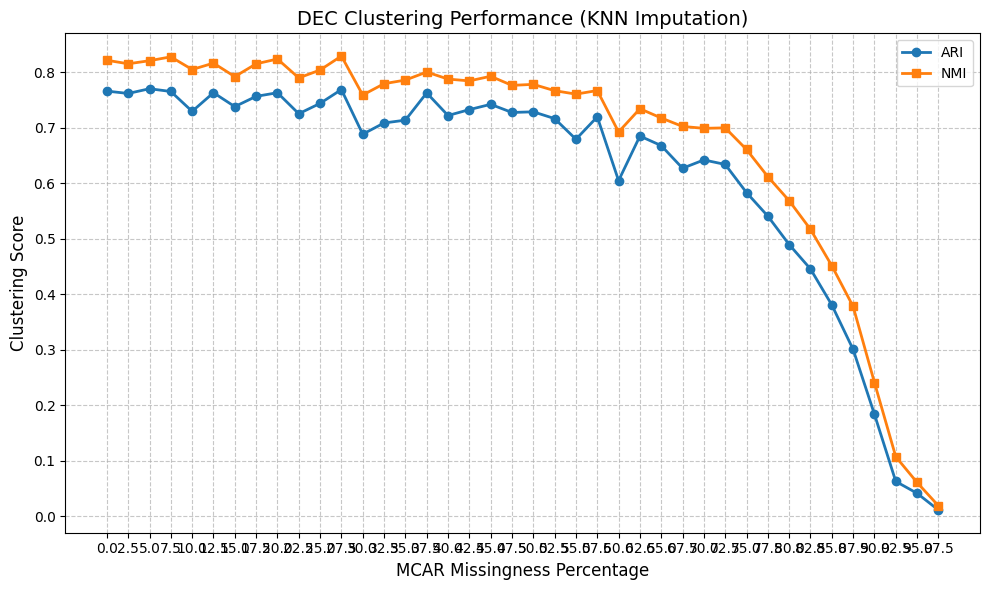

In [7]:
plot_dec_performance(
    missingness_percentages=missingness_percentages,
    score_arrays=[ari_scores_knn, nmi_scores_knn],
    labels=['ARI', 'NMI'],
    title='DEC Clustering Performance (KNN Imputation)'
)

# Mean imputation

In [8]:
ari_scores_mean = []
nmi_scores_mean = []

In [11]:
for mcar_percent in missingness_percentages:
    missing_rate_float = mcar_percent / 100.0

    ari, nmi = run_dec_pipeline(
        X_clean=tensor_x,
        y_true=labels,
        data_indices=indices,
        missingness=missingness,
        corruption_type='mcar',
        missing_rate=missing_rate_float,
        imputer=mean_imputer,
        device=device,
        ae_epochs=30,
        dec_epochs=70
    )

    ari_scores_mean.append(ari)
    nmi_scores_mean.append(nmi)

	No corruption applied
	Running imputation: MeanImageImputer
	- Training Autoencoder
Epoch 5/30: average loss = 0.0181
Epoch 10/30: average loss = 0.0133
Epoch 15/30: average loss = 0.0117
Epoch 20/30: average loss = 0.0107
Epoch 25/30: average loss = 0.0101
Epoch 30/30: average loss = 0.0097
	- Training DEC
Epoch 10/70: average loss = 0.1538
Epoch 20/70: average loss = 0.1199
Epoch 30/70: average loss = 0.1009
Epoch 40/70: average loss = 0.0881
Epoch 50/70: average loss = 0.0784
Epoch 60/70: average loss = 0.0710
Epoch 70/70: average loss = 0.0651
	Evaluation
Result: ARI=0.7366 | NMI=0.8086
	Corrupting data (mcar | 0.03)
	Running imputation: MeanImageImputer
	- Training Autoencoder
Epoch 5/30: average loss = 0.0192
Epoch 10/30: average loss = 0.0147
Epoch 15/30: average loss = 0.0131
Epoch 20/30: average loss = 0.0123
Epoch 25/30: average loss = 0.0117
Epoch 30/30: average loss = 0.0112
	- Training DEC
Epoch 10/70: average loss = 0.1715
Epoch 20/70: average loss = 0.1307
Epoch 30/70: 

In [15]:
results_df = pd.DataFrame({
    'Missingness': missingness_percentages,
    'ARI (Mean-DEC)': ari_scores_mean[4:],
    'NMI (Mean-DEC)': nmi_scores_mean[4:]
})



print(results_df)

    Missingness  ARI (Mean-DEC)  NMI (Mean-DEC)
0           0.0        0.736645        0.808558
1           2.5        0.780259        0.819837
2           5.0        0.700805        0.778973
3           7.5        0.745325        0.808305
4          10.0        0.657685        0.736642
5          12.5        0.731734        0.792748
6          15.0        0.667740        0.748009
7          17.5        0.653183        0.731977
8          20.0        0.719202        0.782941
9          22.5        0.634973        0.715928
10         25.0        0.663233        0.736316
11         27.5        0.680477        0.751640
12         30.0        0.608784        0.708713
13         32.5        0.640263        0.728224
14         35.0        0.637760        0.717920
15         37.5        0.536991        0.646269
16         40.0        0.122244        0.128392
17         42.5        0.097857        0.134815
18         45.0       -0.000003        0.000095
19         47.5        0.076287        0

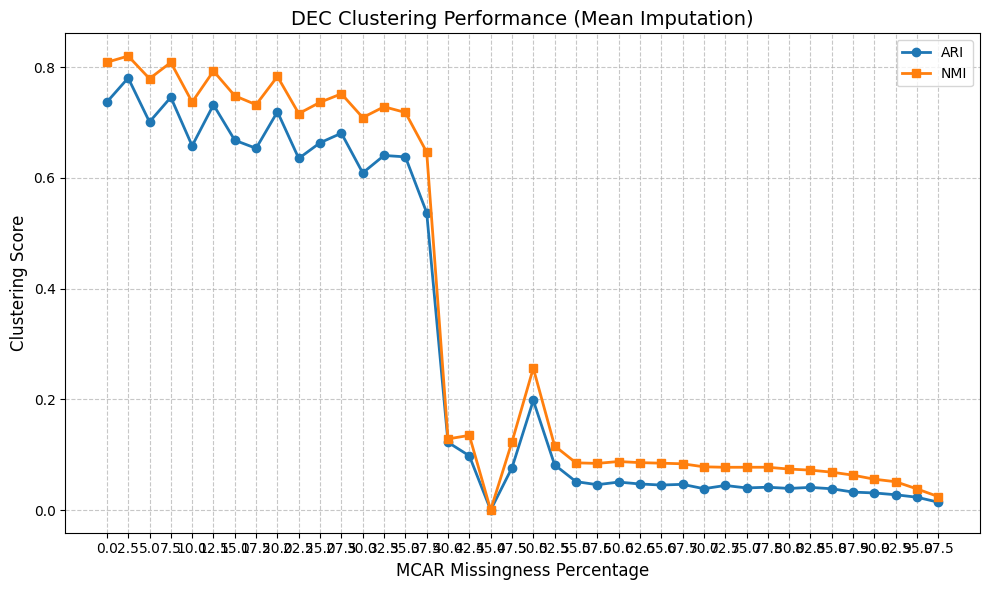

In [17]:
plot_dec_performance(
    missingness_percentages=missingness_percentages,
    score_arrays=[ari_scores_mean[4:], nmi_scores_mean[4:]],
    labels=['ARI', 'NMI'],
    title='DEC Clustering Performance (Mean Imputation)'
)

# Denoising Autoencoder

In [ ]:
# ari_scores_knn = []
# nmi_scores_knn = []
#
# corruption_type = "mcar"
# missingness_percentages = np.arange(0, 30, 10)

In [ ]:
# for mcar_percent in missingness_percentages:
#     missing_rate_float = mcar_percent / 100.0
#     print(f"\n-------- Missingness percentage {missing_rate_float} --------")
#
#     corruption_kwargs = {"missing_rate": missing_rate_float}
#
#     # X_missing_flat, _ = missingness.apply_corruption(
#     #     tensor_x,
#     #     corruption_type='mcar',
#     #     missing_rate=missing_rate_float
#     # )
#     #
#     # X_missing_image = X_missing_flat.view(-1, 1, H_W, H_W)
#     #
#     # X_imputed_image = knn_impute_image(X_missing_image, k=K_KNN)
#     # X_imputed_flat = X_imputed_image.view(-1, N_FEATURES)
#
#     ari, nmi = run_dec_pipeline(
#         tensor_x,
#         labels,
#         indices,
#         device=device,
#         ae_epochs=20,
#         dec_epochs=75,
#         n_clusters=10,
#         latent_dim=10,
#         n_features=784,
#     )
#
#     ari_scores_knn.append(ari)
#     nmi_scores_knn.append(nmi)

# print(f"\n RESULTS ({mcar_percent}% MCAR): ARI={ari:.4f} | NMI={nmi:.4f}")